In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns

In [45]:
data_csv = r"F:\MultiDimensionalAD\data\202505161524GMT+5x30.h24.csv"
df = pd.read_csv(data_csv)

In [34]:
SENSOR_FILTERS = ['-PT-', '-TT-', '-TI-', '-PI-']

In [46]:
df_sensors = df.filter(regex='|'.join(SENSOR_FILTERS))

In [47]:
df_all = df.drop(columns=["Seconds", "Timestamp_IST"], errors="ignore")
df_all.columns
df_all.columns

Index(['MU-FIC-1103-S', 'I2-FIc-2206-S', 'I2-FIc-2205-S', 'WA-FIC-1203-S',
       'I2-FIc-2253-S', 'MA-FIC-1303-S', 'MA-FIC-1353-S', 'I2-FIC-4203',
       'MG-FIC-1703-S', 'MG-FIc-1753-S',
       ...
       'WA-MP-101B', 'WA-MP-101C', 'GUJRI-DRA-PUMP', 'MANMAD-DRA-PUMP',
       'MG-DRA-PUMP', 'GUJRI-DRA-TYPE', 'MANMAD-DRA-TYPE', 'MG-DRA-TYPE',
       'MU-DRA-TYPE', 'WA-DRA-TYPE'],
      dtype='object', length=285)

In [91]:
pca = PCA(n_components=3)
from sklearn.preprocessing import StandardScaler
pca.fit(StandardScaler().fit_transform(df_sensors.values[:5]))
sensors_pca = pca.transform(StandardScaler().fit_transform(df_sensors.values))


print(df_sensors.columns)

Index(['GU-PI-1901', 'GU-PI-1915', 'JK-PI-1501', 'JK-PI-1503', 'JW-PI-1601',
       'JW-PI-1603', 'I2-PI-2205', 'MA-PI-1307', 'MA-PI-1359', 'MG-PI-1701',
       ...
       'S32-TI-1432A', 'S32-TI-1432B', 'S33-TI-1433A', 'S33-TI-1433B',
       'S34-TI-1434A', 'S34-TI-1434B', 'S35-TI-1435A', 'S35-TI-1435B',
       'WA-TI-1201', 'WA-TI-1205'],
      dtype='object', length=133)


(17256, 133)


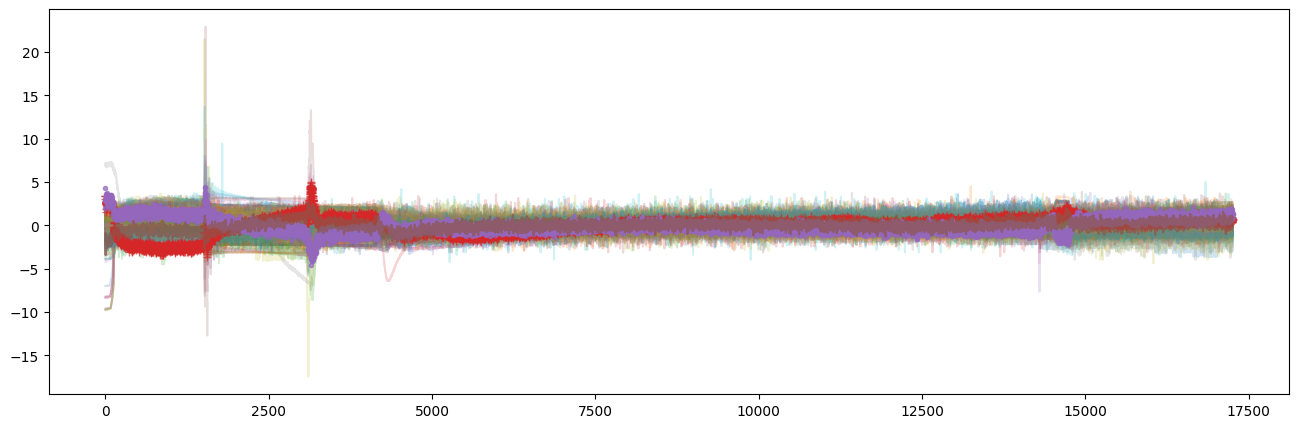

In [92]:
plot_sensors = StandardScaler().fit_transform(df_sensors.values)
print(plot_sensors.shape)
plt.figure(figsize=(16,5))
for item in plot_sensors.T:
    plt.plot(item, alpha=0.2)
plt.plot(sensors_pca[:,0], '+', alpha=0.7)
plt.plot(sensors_pca[:,2], '.', alpha=0.7)
plt.plot(sensors_pca[:,1], '-', alpha=0.7)
plt.show()

In [82]:
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

plot_sensors = StandardScaler().fit_transform(df_sensors.values)
print(plot_sensors.shape)

fig = go.Figure()

# ---- Sensor signals (GPU, no hover) ----
for i in range(plot_sensors.shape[1]):
    fig.add_trace(
        go.Scattergl(
            y=plot_sensors[:, i],
            mode="lines",
            line=dict(width=1),
            opacity=0.3,
            hoverinfo="skip",   # 🔴 disable hover
            showlegend=False
        )
    )

# ---- PCA components ----
fig.add_trace(
    go.Scattergl(
        y=sensors_pca[:, 0],
        mode="markers",
        marker=dict(size=4),
        name="PCA-0",
        hoverinfo="skip"
    )
)

fig.add_trace(
    go.Scattergl(
        y=sensors_pca[:, 1],
        mode="lines",
        name="PCA-1",
        hoverinfo="skip"
    )
)

fig.add_trace(
    go.Scattergl(
        y=sensors_pca[:, 2],
        mode="markers",
        marker=dict(size=3),
        name="PCA-2",
        hoverinfo="skip"
    )
)

# ---- Layout tuning ----
fig.update_layout(
    title=None,
    autosize=True,
    height=550,
    margin=dict(l=30, r=10, t=10, b=30),
    hovermode=False,        # 🔴 kill hover globally
    xaxis=dict(fixedrange=False),
    yaxis=dict(fixedrange=False),
)

# ---- Make it full-width + fast ----
fig.write_html(
    "interactive.html",
    include_plotlyjs="cdn",
    full_html=True,
    config={
        "responsive": True,
 # 🔴 faster
        "scrollZoom": True
    },
    auto_open=True
)


(17256, 133)


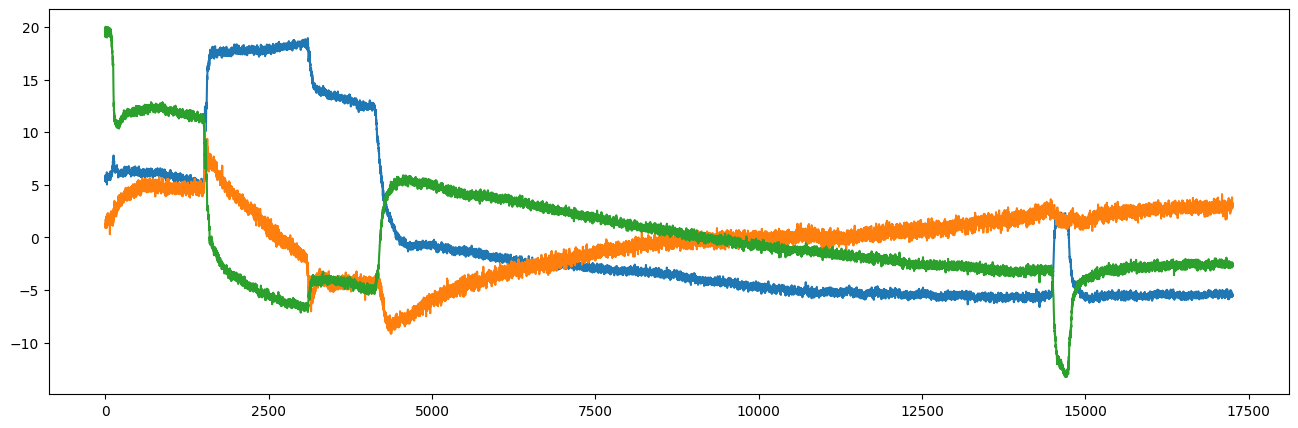

In [68]:
plt.figure(figsize=(16, 5))
plt.plot(sensors_pca[:,0])
plt.plot(sensors_pca[:,2])
plt.plot(sensors_pca[:,1])
plt.show()

In [93]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

Explained variance ratio: [0.33768082 0.2835341  0.22763378]


0.848848695112368

In [50]:
# now let's take all
pca = PCA(n_components=3)
from sklearn.preprocessing import StandardScaler
sensors_pca = pca.fit_transform(StandardScaler().fit_transform(df_all.values))

In [51]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

Explained variance ratio: [0.41819902 0.17364054 0.07357555]


0.6654151154727634

Samples: 86400, Sensors: 19


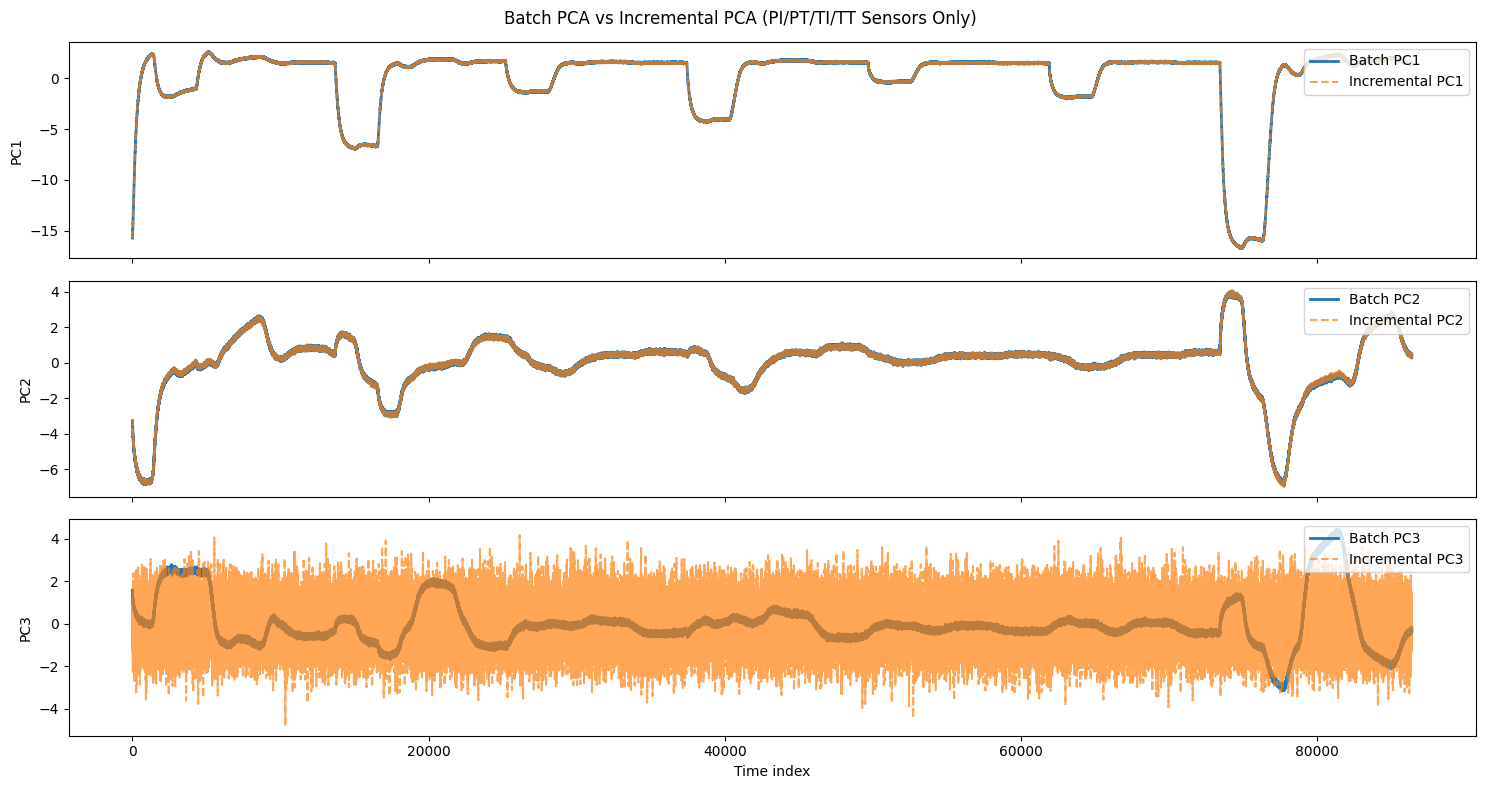

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

# ---------------- CONFIG ----------------
CSV_PATH = r"F:\MultiDimensionalAD\data\long_run_labelled.csv"

DROP_COLS = ["Seconds", "Timestamp_IST", "State", "label"]
SENSOR_TAGS = ("PI", "PT", "TI", "TT")

N_COMPONENTS = 3
IPCA_BATCH = 170

# ---------------- LOAD ----------------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

sensor_cols = [
    c for c in df.columns
    if any(tag in c for tag in SENSOR_TAGS)
]

df_sensors = df[sensor_cols]
X = df_sensors.values.astype(np.float64)

n_samples, n_features = X.shape
print(f"Samples: {n_samples}, Sensors: {n_features}")

# ---------------- SCALE (ONCE) ----------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =======================
# 1️⃣ BATCH PCA (FULL DATA)
# =======================
pca = PCA(n_components=N_COMPONENTS)
Z_batch = pca.fit_transform(X_scaled)

# ==========================
# 2️⃣ INCREMENTAL PCA (ONLINE)
# ==========================
ipca = IncrementalPCA(n_components=N_COMPONENTS, batch_size=IPCA_BATCH)

Z_incr = np.zeros((n_samples, N_COMPONENTS))

for i in range(0, n_samples, IPCA_BATCH):
    X_chunk = X_scaled[i : i + IPCA_BATCH]
    ipca.partial_fit(X_chunk)

# second pass to project (important)
for i in range(0, n_samples, IPCA_BATCH):
    X_chunk = X_scaled[i : i + IPCA_BATCH]
    Z_incr[i : i + IPCA_BATCH] = ipca.transform(X_chunk)

# ---------------- PLOT ----------------
t = np.arange(n_samples)

fig, axes = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

for k in range(3):
    axes[k].plot(t, Z_batch[:, k], label=f"Batch PC{k+1}", linewidth=2)
    axes[k].plot(
        t,
        Z_incr[:, k],
        linestyle="--",
        alpha=0.7,
        label=f"Incremental PC{k+1}",
    )
    axes[k].set_ylabel(f"PC{k+1}")
    axes[k].legend(loc="upper right")

axes[-1].set_xlabel("Time index")
fig.suptitle("Batch PCA vs Incremental PCA (PI/PT/TI/TT Sensors Only)")
plt.tight_layout()
plt.show()


Samples: 86400, Sensors: 19


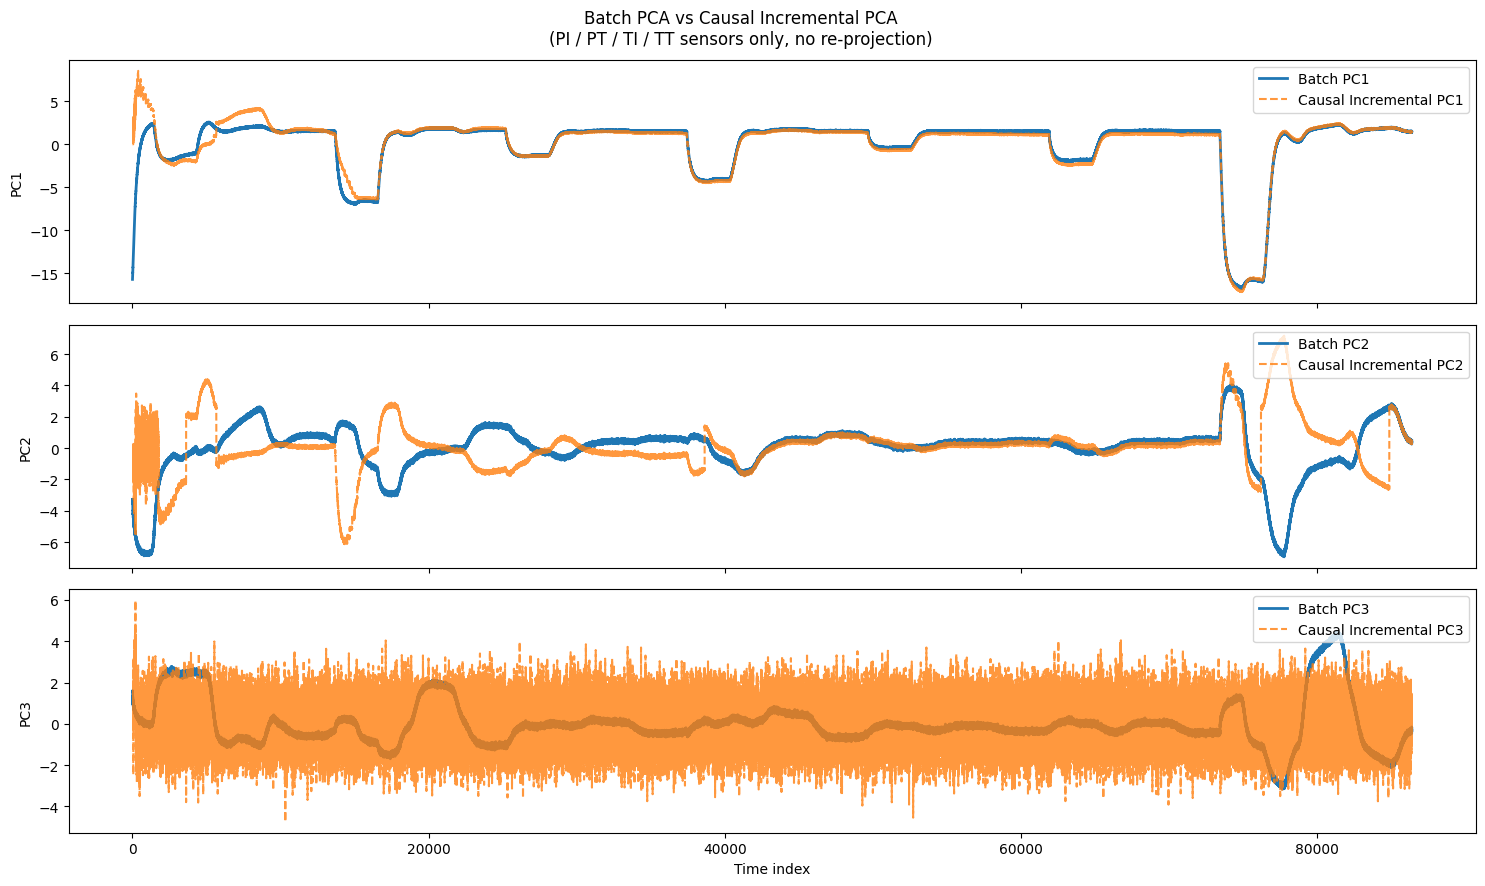

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

# ---------------- CONFIG ----------------
CSV_PATH = r"F:\MultiDimensionalAD\data\long_run_labelled.csv"

DROP_COLS = ["Seconds", "Timestamp_IST", "State", "label"]
SENSOR_TAGS = ("PI", "PT", "TI", "TT")

N_COMPONENTS = 3
WARMUP = 50
IPCA_BATCH = 170

# ---------------- LOAD ----------------
df = pd.read_csv(CSV_PATH)
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

sensor_cols = [
    c for c in df.columns
    if any(tag in c for tag in SENSOR_TAGS)
]

X = df[sensor_cols].values.astype(np.float64)
n_samples, n_features = X.shape

print(f"Samples: {n_samples}, Sensors: {n_features}")

# ---------------- SCALE (ONCE, GLOBAL) ----------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =======================
# 1️⃣ BATCH PCA (GLOBAL)
# =======================
pca = PCA(n_components=N_COMPONENTS)
Z_batch = pca.fit_transform(X_scaled)

# ===============================
# 2️⃣ CAUSAL INCREMENTAL PCA
# ===============================
ipca = IncrementalPCA(n_components=N_COMPONENTS)

# warmup
ipca.fit(X_scaled[:WARMUP])

Z_causal = np.zeros((n_samples, N_COMPONENTS))
buffer = []

for t in range(WARMUP, n_samples):

    x = X_scaled[t].reshape(1, -1)

    # project with CURRENT basis
    Z_causal[t] = ipca.transform(x)[0]

    buffer.append(x[0])

    # update PCA basis occasionally
    if len(buffer) >= IPCA_BATCH:
        ipca.partial_fit(np.array(buffer))
        buffer.clear()

# =======================
# 3️⃣ COMPARISON PLOT
# =======================
t = np.arange(n_samples)

fig, axes = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

for k in range(3):
    axes[k].plot(
        t, Z_batch[:, k],
        label=f"Batch PC{k+1}",
        linewidth=2
    )
    axes[k].plot(
        t, Z_causal[:, k],
        linestyle="--",
        alpha=0.8,
        label=f"Causal Incremental PC{k+1}"
    )

    axes[k].set_ylabel(f"PC{k+1}")
    axes[k].legend(loc="upper right")

axes[-1].set_xlabel("Time index")
fig.suptitle(
    "Batch PCA vs Causal Incremental PCA\n"
    "(PI / PT / TI / TT sensors only, no re-projection)"
)
plt.tight_layout()
plt.show()
